# The flipped profile problem

We saw suspiciously high surface fluxes in our warming simulations and did not understand what was causing them. I identified the surface gradient as the cause. This strong gradient is visible in the longitudinal cross section through near surface temperatures in the domain. The airmass entering from the East (following the trade winds) experiences a strong warming on the first quarter of its transect. It starts with a visible mismatch to the *should be* boundary conditions. 

![](img/fig_lon_crosssection_boundaries_temp.png)

The boundary conditions seem to not have been warmed at all. The control case boundary condition (black marker) fits the cross section much better than the warmed case (red marker). The look into the vertical profile of our boundary conditions reveals the cause: The warming signal has been applied flipped upside down. But why? And why did I not notice this before?

I adjusted the warming function to correct the flipped profile. Yet somehow the function I use to warm the profile does seem to have a different effect on the actual boundary conditions (labeled *warming bc* below), than it does on my test cases (labeled *warmed control bc* below) which now, with the supposedly fixed function.  

![](img/fig_compare_boundary_condition_profiles.png)



![](img/fixedfig_latbc_initc_sst_quick_comparison.png)

1023 /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc
1023 /work/mh1126/m300872/moist_adiabatic_rhofix/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc


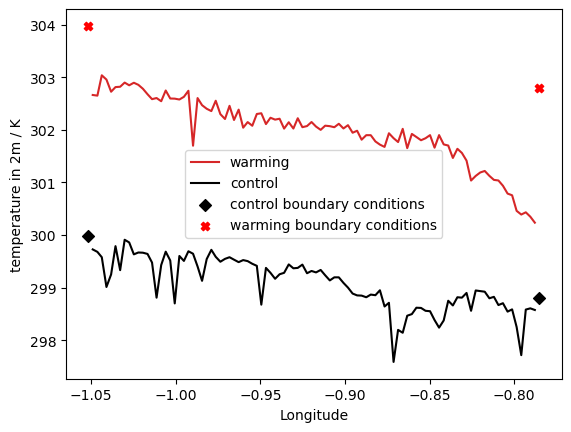

In [2]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc
import matplotlib.pyplot as plt

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_compare_longitudinal_sections(varname='t_2m', time_index=143):
    fig, ax = plt.subplots()
    
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup'
    data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    data = data.isel(time=time_index)
    data = pp.add_grid(data)
    timestep = data.time.values
    ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':'warming'})

    data = fh.eureca_data_from_keywords(['surface','DOM01'])
    data = data.sel(time=timestep)
    data = pp.add_grid(data)
    ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':'control'})
    return fig, ax

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    print(len(files), files[0])
    dataset = xr.open_dataset(files[0])
    # dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.rename({'ncells':'cell'})
    dataset = pp.add_grid(dataset, grid_path=os.path.join(path,'lateral_boundary_DOM01.grid.nc'))
    return dataset

def ax_longitudinal_section_boundaries(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_fig_lon_crosssection_boundaries():
    fig, ax = fig_compare_longitudinal_sections('t_2m')

    var = 'temp'

    kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
    data = open_boundary_conditions()
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'X'}
    data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/')
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    ax.legend()
    return fig, ax

fig, ax = fig_fig_lon_crosssection_boundaries()
fig.savefig('img/fig_lon_crosssection_boundaries.png')
fig.show()

In [9]:
'latbc_Testdomain_land'
l = ['latbc_Testdomain_land_DOM01', '.nc']
IN_DIRECTORY = '/work/mh1126/m300872/unchanged/'
fh.list_files(IN_DIRECTORY, l)

['dev/latbc/20200215/latbc_Testdomain_land_DOM01_DOM01_2020021500.nc',
 'dev/latbc/20200215/latbc_Testdomain_land_DOM01_DOM01_2020021510.nc',
 'dev/latbc/20200215/latbc_Testdomain_land_DOM01_DOM01_2020021511.nc',
 'dev/latbc/20200215/latbc_Testdomain_land_DOM01_DOM01_2020021512.nc',
 'dev/latbc/20200215/latbc_Testdomain_land_DOM01_DOM01_2020021513.nc']

In [131]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh

def try_remove(path):
    try:os.remove(path)
    except: pass

in_directory='/work/mh1126/m300872/unchanged/'
out_directory='/work/mh1126/m300872/test/'
warming_function = 'apply_warming_rho_fixed'
keywords = ['latbc', 'PR1250m_DOM01', '.nc']

latbc_file = fh.list_files(in_directory, keywords)[0]
ifile = os.path.join(in_directory,  latbc_file)
ofile = os.path.join(out_directory, latbc_file)
varnames = cc.get_varnames({"pressure" : "pres", "temperature" : "temp"})

d = xr.open_dataset(file)
d = cc.apply_warming_rho_fixed(d, varnames)
fh.create_directory_structure([latbc_file], out_directory)
try_remove(ofile)
d.to_netcdf(ofile)

xr.open_dataset(ifile).temp.values[0,74,9999], xr.open_dataset(ofile).temp.values[0,74,9999]

(299.99268, 303.99268)

In [112]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import subprocess as sup

def latbc_script_body(warming_function, in_directory, out_directory, match_keywords, 
                      division=False, temperatures=(304,300)):
    return f'''
def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    print(d[varnames['temperature']].values, flush=True) #db
    d = {warming_function}(d, varnames=varnames)
    print(d[varnames['temperature']].values, flush=True) #db
    d.to_netcdf(ofile)
    
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
latbc_files = list_files(IN_DIRECTORY, {match_keywords})
if division: latbc_files = sublist(latbc_files, division[0], division[1])

# In case of a failed script, I want to know in details what script to relaunch
# therefore here comes some printout
print('latbc_script', flush=True)
print('IN_DIRECTORY: ', IN_DIRECTORY, flush=True)
print('OUT_DIRECTORY: ', OUT_DIRECTORY, flush=True)
print('division: ', division, flush=True)
for f in latbc_files: print(f, flush=True)
print('', flush=True)

# make sure directory structure is there
create_directory_structure(latbc_files, OUT_DIRECTORY)

# Compile arguments
varnames = get_varnames({"pressure" : "pres", "temperature" : "temp"})
args_list = list()
for f in latbc_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile, ofile, varnames))

# Do the work
for args in args_list:
    print(args, flush=True)
    warm_atmospheric_profile(*args)

print('done', flush=True)
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)

def launch_latbc_scripts(in_directory='/work/mh1126/m300872/unchanged/', 
                         out_directory='/work/mh1126/m300872/test/',
                         warming_function = 'apply_warming_rho_fixed',
                         keywords = ['latbc', 'PR1250m_DOM01', '.nc'],
                         n_scripts=100):
    for script_id in range(n_scripts):
        division=(n_scripts, script_id)
        script = create_latbc_script(in_directory, out_directory, warming_function, keywords, division)
        launch_script(script)
        
def create_latbc_script(in_directory='/work/mh1126/m300872/unchanged/',
                        out_directory='/work/mh1126/m300872/test/',
                        warming_function='apply_warming_rho_fixed',
                        keywords=['latbc', 'PR1250m_DOM01', '.nc'],
                        division=None,
                        verbose=False):
    if verbose: 
        latbc_files = fh.list_files(in_directory, keywords)
        print(division)
        if not division == None: latbc_files = fh.sublist(latbc_files, division[0], division[1])
        for f in latbc_files: print('  ', f)
    script = fh.slurm_header(10) + fh.some_module_files() + \
             latbc_script_body(warming_function, in_directory, out_directory, keywords, division=division)
    return script

in_directory  = '/work/mh1126/m300872/unchanged/'
out_directory = '/work/mh1126/m300872/moist_adiabatic_rhofix/'
warming_function = 'apply_warming_rho_fixed'
keywords = ['latbc', 'PR1250m_DOM01', '.nc']

# launch all scripts
# launch_latbc_scripts(in_directory, out_directory, warming_function, keywords, 100)

# # relaunch of failed scripts (i receive emails for failed scripts):
# for division in [(1000, 0)]:
#     script = create_latbc_script(in_directory, out_directory, warming_function, keywords, division, verbose=True)
#     launch_script(script)

Submitted batch job 7971462
Submitted batch job 7971463
Submitted batch job 7971464
Submitted batch job 7971465
Submitted batch job 7971466
Submitted batch job 7971467
Submitted batch job 7971468
Submitted batch job 7971469
Submitted batch job 7971470
Submitted batch job 7971471
Submitted batch job 7971472
Submitted batch job 7971473
Submitted batch job 7971474
Submitted batch job 7971475
Submitted batch job 7971476
Submitted batch job 7971477
Submitted batch job 7971478
Submitted batch job 7971479
Submitted batch job 7971480
Submitted batch job 7971481
Submitted batch job 7971482
Submitted batch job 7971483
Submitted batch job 7971484
Submitted batch job 7971485
Submitted batch job 7971486
Submitted batch job 7971487
Submitted batch job 7971488
Submitted batch job 7971489
Submitted batch job 7971490
Submitted batch job 7971491
Submitted batch job 7971492
Submitted batch job 7971493
Submitted batch job 7971494
Submitted batch job 7971495
Submitted batch job 7971496
Submitted batch job 

1023 /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc
1023 /work/mh1126/m300872/moist_adiabatic_rhofix/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc


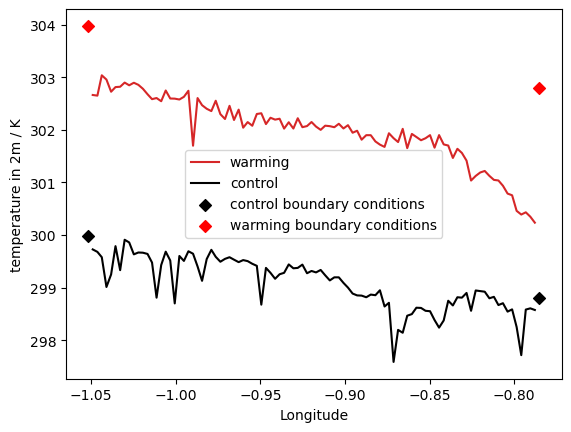

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc
import matplotlib.pyplot as plt

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_compare_longitudinal_sections(varname='t_2m', time_index=143):
    fig, ax = plt.subplots()
    
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup'
    data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    data = data.isel(time=time_index)
    data = pp.add_grid(data)
    timestep = data.time.values
    ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':'warming'})

    data = fh.eureca_data_from_keywords(['surface','DOM01'])
    data = data.sel(time=timestep)
    data = pp.add_grid(data)
    ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':'control'})
    return fig, ax

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    print(len(files), files[0])
    dataset = xr.open_dataset(files[0])
    # dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.rename({'ncells':'cell'})
    dataset = pp.add_grid(dataset, grid_path=os.path.join(path,'lateral_boundary_DOM01.grid.nc'))
    return dataset

def ax_longitudinal_section_boundaries(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_fig_lon_crosssection_boundaries():
    fig, ax = fig_compare_longitudinal_sections('t_2m')

    var = 'temp'

    kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
    data = open_boundary_conditions()
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'D'}
    data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/')
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    ax.legend()
    return fig, ax

fig, ax = fig_fig_lon_crosssection_boundaries()
fig.savefig('img/fig_lon_crosssection_boundaries_temp.png')
fig.show()

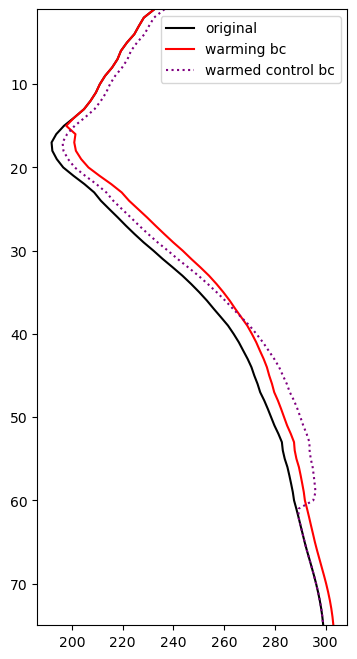

In [113]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import xarray as xr
import calculations as cc
import matplotlib.pyplot as plt
import numpy as np

import importlib
importlib.reload(cc)

def fig_compare_boundary_condition_profiles():
    bc_dir  = '/work/mh1126/m300872/unchanged/'
    bc_file = 'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010812.nc'
    path = os.path.join(bc_dir, bc_file)

    profiles, kwargs = list(), list()
    profile = xr.open_dataset(os.path.join(bc_dir, bc_file))
    profile = profile.isel(time=0).median(dim='ncells', keep_attrs=True)
    profile = cc.add_relative_humidity(profile)
    profiles.append(profile)
    kwargs.append({'label':'original', 'color':'black'})

    profile = xr.open_dataset(os.path.join('/work/mh1126/m300872/moist_adiabatic_rhofix/', bc_file))
    profile = profile.isel(time=0).median(dim='ncells', keep_attrs=True)
    profile = cc.add_relative_humidity(profile)
    profiles.append(profile)
    kwargs.append({'label':'warming bc', 'color':'red'})

    profile = xr.open_dataset(path).isel(time=0).median(dim='ncells')
    varnames = cc.get_varnames()
    varnames['full_level_height'] = 'height_3'
    profile = cc.apply_warming_rho_fixed(profile, varnames)
    profile = cc.add_relative_humidity(profile)
    profiles.append(profile)
    kwargs.append({'label':'warmed control bc', 'color':'purple', 'ls':':'})

    var = 'temp'

    fig, ax = plt.subplots(figsize=(4,8))
    for profile, kwarg in zip(profiles, kwargs):
        ax.plot(profile[var].values, profile[profile[var].dims[0]].values, **kwarg)
    ax.set_ylim(profile[profile.qv.dims[0]].values[-1], profile[profile.qv.dims[0]].values[0])
    ax.legend()
    try:    ax.set_xlabel(f'{warming[var].attrs["long_name"]} / {warming[var].attrs["units"]}')
    except: pass
    return fig, ax

fig, ax = fig_compare_boundary_condition_profiles()
fig.savefig('img/fig_compare_boundary_condition_profiles.png')
fig.show()

In [159]:
def initc_script_body(in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/test/',
                      warming_function='apply_warming_rho_fixed'):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = [os.path.join('initc',f) for f in list_files(os.path.join(IN_DIRECTORY, 'initc'))]
create_directory_structure(initc_files, OUT_DIRECTORY)

for f in initc_files: print(f, flush=True)
print('', flush=True)

def warm_atmospheric_profile(ifile, ofile, varnames=None):
    d = xr.open_dataset(ifile)
    d = {warming_function}(d, varnames=varnames)
    d = add_prognostic_variables(d, varnames=varnames)
    d.to_netcdf(ofile)

initcon_varnames = dict()
initcon_varnames["pressure"] = "p"
initcon_varnames["temperature"] = "t"
varnames = get_varnames(initcon_varnames)
print(varnames, flush=True)
print('', flush=True)

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
warm_atmospheric_profile(ifile, ofile, varnames)
print('done', flush=True)
'''

def launch_initc_script(in_directory='/work/mh1126/m300872/unchanged/',
                        out_directory='/work/mh1126/m300872/test/',
                        warming_function='apply_warming_rho_fixed'):
    script = fh.slurm_header(10) + fh.some_module_files() + \
             initc_script_body(in_directory, out_directory, warming_function)
    launch_script(script)

    
in_directory='/work/mh1126/m300872/unchanged/'
out_directory='/work/mh1126/m300872/moist_adiabatic_rhofix/'
warming_function='apply_warming_rho_fixed'

launch_initc_script(in_directory, out_directory, warming_function)

Submitted batch job 7994254


In [67]:
import subprocess as sup

def sstsic_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic_rhofix/',
                      temperatures=(300,304)):
    return f'''
import netCDF4 as nc
import xarray as xr
import subprocess as sup

IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
temperatures = {temperatures}

print(division)
sstsic_files = list_files(os.path.join(IN_DIRECTORY, 'sst_sic'), ['sst_sic_DOM0'])
sstsic_files = [os.path.join('sst_sic',f) for f in sstsic_files if f.endswith('.nc')]
if division: sstsic_files = sublist(sstsic_files, division[0], division[1])
create_directory_structure(sstsic_files, OUT_DIRECTORY)
    
# pack arguments
delta = temperatures[1] - temperatures[0]
args_list = list()
for f in sstsic_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,delta))

for args in args_list:
    # copy original file, then overwrite SST timestepwise (file to big to write at once)
    (ifile, ofile, delta) = args
    sup.call(['cp', ifile, ofile])
    time_shape = xr.open_dataset(ifile).time.values.shape
    with nc.Dataset(args[1], mode='a') as fp:
        for i in range(time_shape[0]):
            chunk = xr.open_dataset(ifile)['SST'].isel(time=i).values + delta
            fp['SST'][i] = chunk
            
print('done', flush=True)
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)

def launch_sstsic_script(n_scripts=3):
    for script_id in range(n_scripts):
        script = fh.slurm_header(15) + fh.some_module_files() + \
                 sstsic_script_body(division=(n_scripts, script_id))
        launch_script(script)
        
launch_sstsic_script()

Submitted batch job 7987764
Submitted batch job 7987765
Submitted batch job 7987766


#################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

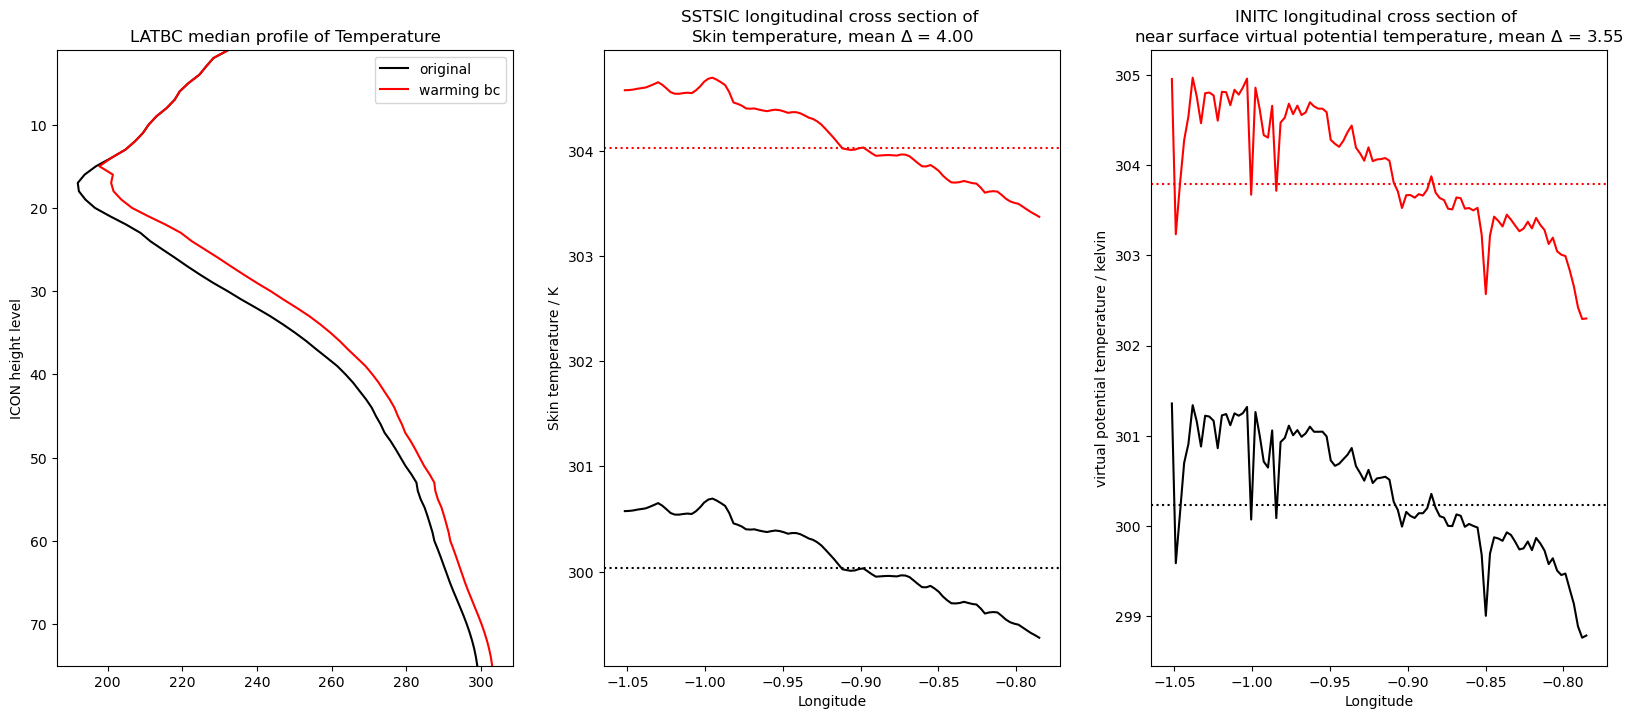

In [5]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc

import matplotlib.pyplot as plt

def open_initc_data(bc_dir, 
                    initc_rel_path='initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
                    grid_path=None):
    data = xr.open_dataset(os.path.join(bc_dir, initc_rel_path))
    data = pp.clean_volume_data(data, convert_time=False)
    data = data.isel(time=0) 
    data = pp.add_grid(data, grid_path)
    data = data.isel(height=len(data.height.values)-1)
    return data

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def ax_initc_cross_section_comparison(ax, bc_dirs, varname):
    initc_rel_path='initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
    grid_path = os.path.join(bc_dirs[0], 'grids/EUREC4A_PR1250m_DOM01.nc')

    data = [open_initc_data(dir_path, grid_path=grid_path) for dir_path in bc_dirs]
    kwargs = [{'color':'black', 'label':fh.basename(bc_dirs[0])}, {'color':'red', 'label':fh.basename(bc_dirs[1])}]

    for d, kw in zip(data, kwargs):
        ax = ax_longitudinal_section(ax, d, varname, kw)
        ax.axhline(d[varname].mean(dim='cell'), ls=':', **kw)
    mean_diff = np.abs(data[0][varname].mean(dim="cell").values - data[1][varname].mean(dim="cell").values)
    ax.set_title(f'INITC longitudinal cross section of \nnear surface {d[varname].attrs["long_name"]}, mean $\Delta$ = {mean_diff:.2f}')
    return ax

def open_sstsic_data(bc_dir, initc_rel_path='sst_sic/data/sst_sic_DOM01.nc'):
    data = xr.open_dataset(os.path.join(bc_dir, initc_rel_path))
    # data = pp.clean_surface_data(data, convert_time=False)
    data = data.isel(time=0) 
    data = data.rename({'clon':'lon', 'clat':'lat'})
    # data = pp.add_grid(data, grid_path)
    # data = data.isel(height=len(data.height.values)-1)
    return data


def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def ax_sst_cross_section_comparison(ax, bc_dirs, varname):
    initc_rel_path='initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
    grid_path = os.path.join(bc_dirs[0], 'grids/EUREC4A_PR1250m_DOM01.nc')

    data = [open_sstsic_data(dir_path) for dir_path in bc_dirs]
    kwargs = [{'color':'black', 'label':fh.basename(bc_dirs[0])}, {'color':'red', 'label':fh.basename(bc_dirs[1])}]

   
    for d, kw in zip(data, kwargs):
        ax = ax_longitudinal_section(ax, d, varname, kw)
        ax.axhline(d[varname].mean(dim='cell'), ls=':', **kw)
    mean_diff = np.abs(data[0][varname].mean(dim="cell").values - data[1][varname].mean(dim="cell").values)
    ax.set_title(f'SSTSIC longitudinal cross section of \n{d[varname].attrs["long_name"]}, mean $\Delta$ = {mean_diff:.2f}')
    return ax

def open_latbc_data_profile(bc_dir, latbc_rel_path='latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010812.nc'):
    data = xr.open_dataset(os.path.join(bc_dir, latbc_rel_path))
    data = data.isel(time=0).median(dim='ncells', keep_attrs=True)
    data = cc.add_relative_humidity(data)
    return data

def ax_compare_boundary_condition_profiles(ax, bc_dirs, varname='temp'):
    data = [open_latbc_data_profile(bc) for bc in bc_dirs]
    kwargs = [{'label':'original', 'color':'black'}, {'label':'warming bc', 'color':'red'}]
    
    for d, kwarg in zip(data, kwargs):
        ax.plot(d[varname].values, d[d[varname].dims[0]].values, **kwarg)
    ax.set_ylim(d[d.qv.dims[0]].values[-1], d[d.qv.dims[0]].values[0])
    ax.legend()
    try:    ax.set_xlabel(f'{warming[varname].attrs["long_name"]} / {warming[varname].attrs["units"]}')
    except: pass
    ax.set_ylabel('ICON height level')
    ax.set_title(f'LATBC median profile of {d[varname].attrs["long_name"]}')
    return ax


def fixedfig_latbc_initc_sst_quick_comparison():
    bc_ctrl = '/work/mh1126/m300872/unchanged/'
    bc_warm = '/work/mh1126/m300872/moist_adiabatic_rhofix/'
    fig, axs = plt.subplots(1,3, figsize=(20,8))
    ax_compare_boundary_condition_profiles(axs[0], [bc_ctrl, bc_warm])
    ax_sst_cross_section_comparison(axs[1], [bc_ctrl, bc_warm], 'SST')
    ax_initc_cross_section_comparison(axs[2], [bc_ctrl, bc_warm], 'theta_v')
    return fig, axs

fig, ax = fixedfig_latbc_initc_sst_quick_comparison()
fig.savefig('img/fixedfig_latbc_initc_sst_quick_comparison.png')
fig.show()

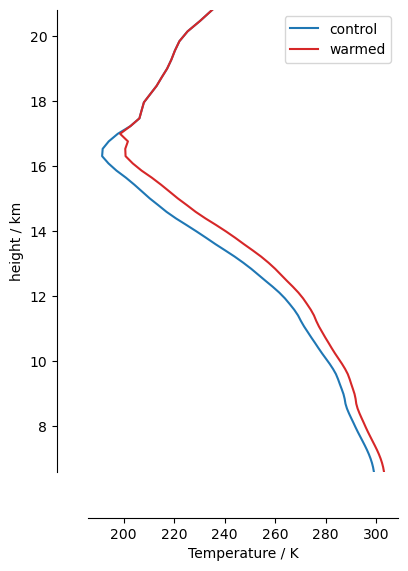

In [39]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import xarray as xr
import file_handling as fh
import metpy.calc
import metpy.units
import postprocessing as pp
# import eurec4a
import calculations as cc

import matplotlib.pyplot as plt
import plot_utils as pu

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    dataset = xr.open_mfdataset(files[0])
    dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    return dataset

def ax_vertical_profile(ax, dataset, var, kwargs={}):
    ax.plot(dataset[var], dataset[dataset[var].dims[0]].values / 1000, **kwargs)
    ax.set_ylim(dataset[dataset[var].dims[0]].values[-1] / 1000, dataset[dataset[var].dims[0]].values[0] / 1000)
    ax.set_ylabel('height / km')
    try: ax.set_xlabel(dataset[var].attrs['long_name'] + ' / ' + dataset[var].attrs['units'] )
    except: pass
    # https://matplotlib.org/2.0.2/examples/pylab_examples/spine_placement_demo.html
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('axes', -.1)) #
    ax.spines['left'  ].set_position(('axes', -.1)) # 
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    return ax

var = 'temp'
dataset = open_boundary_conditions().isel(time=0)

fig, ax = plt.subplots(figsize=(4,6))
dataset = cc.add_relative_humidity(dataset)
dataset = cc.replace_level_with_height(dataset, dataset[var].dims[0])
ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:blue', 'label':'control'})
dataset = cc.apply_warming_rho_fixed(dataset)
dataset = cc.add_relative_humidity(dataset)
ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:red', 'label':'warmed'})
ax.legend()

fig.show()

1023 /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc
1023 /work/mh1126/m300872/moist_adiabatic_rhofix/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc


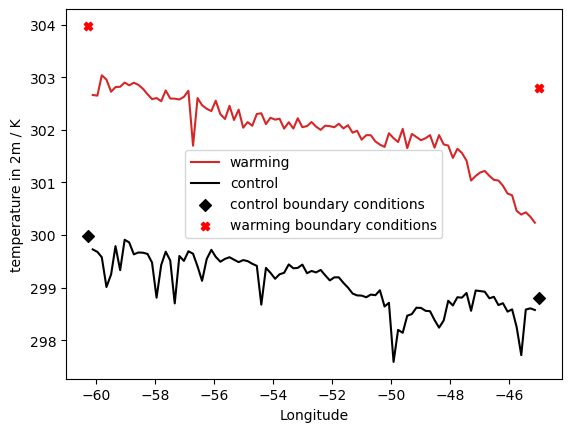

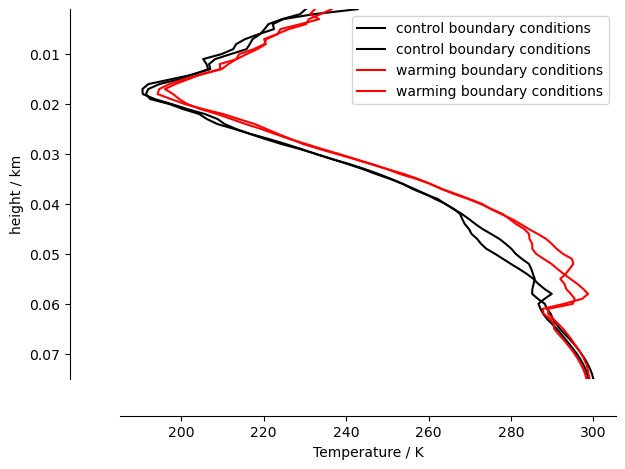

In [45]:
import plot_utils as pu

fig, ax = plt.subplots()
var = 'temp'

kwargs = {'label':'control boundary conditions', 'color':'black'}
data = open_boundary_conditions()
lon = np.asarray(cc.minmax(data.lon))
lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
data = cc.select_nearest_cells(data, lon, lat)
data = data.isel(time=0)
# data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
pu.ax_vertical_profile(ax, data.isel(cell=0), var, kwargs=kwargs)
pu.ax_vertical_profile(ax, data.isel(cell=1), var, kwargs=kwargs)

kwargs = {'label':'warming boundary conditions', 'color':'red'}
data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic/latbc/')
lon = np.asarray(cc.minmax(data.lon))
lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
data = cc.select_nearest_cells(data, lon, lat)
data = data.isel(time=0)
# data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
# ax.scatter(data.lon.values, data[var].values, **kwargs)
pu.ax_vertical_profile(ax, data.isel(cell=0), var, kwargs=kwargs)
pu.ax_vertical_profile(ax, data.isel(cell=1), var, kwargs=kwargs)

ax.legend()
# ax = ax_longitudinal_section_boundaries(ax, data, var, kwargs={})
fig.show()

In [21]:
fig, ax = fig_compare_longitudinal_sections('qv_2m')
fig.show()

NameError: name 'fig_compare_longitudinal_sections' is not defined

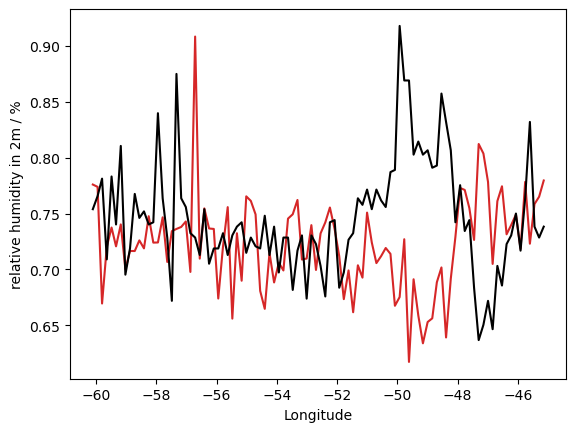

In [32]:
fig, ax = fig_compare_longitudinal_sections('rh_2m')
fig.show()

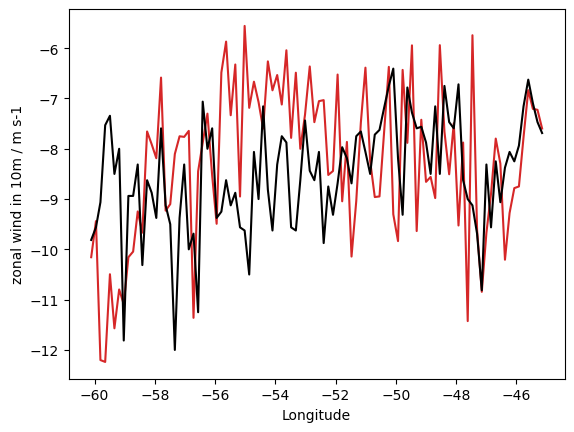

In [34]:
fig, ax = fig_compare_longitudinal_sections('u_10m')
fig.show()

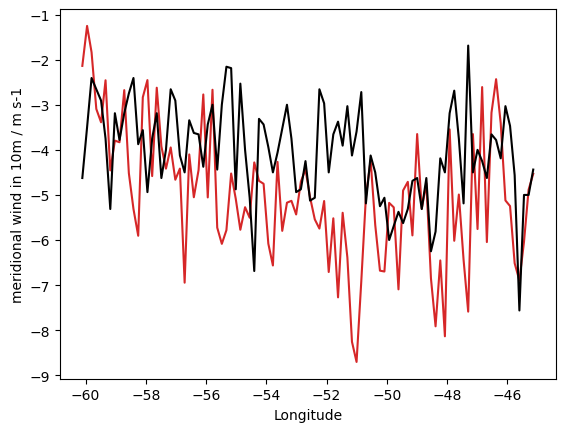

In [35]:
fig, ax = fig_compare_longitudinal_sections('v_10m')
fig.show()

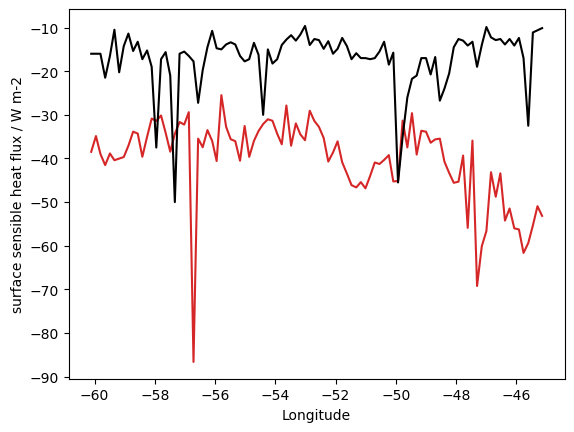

In [36]:
fig, ax = fig_compare_longitudinal_sections('shfl_s')
fig.show()

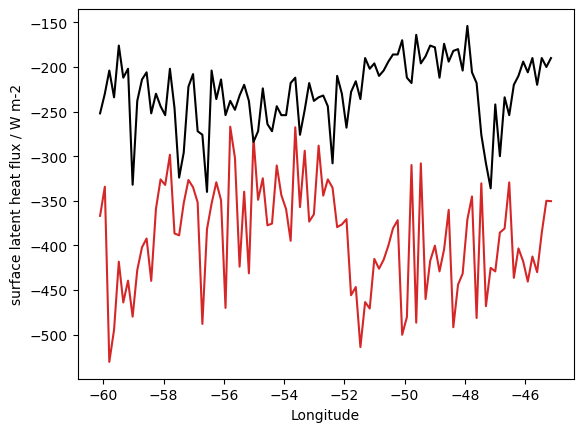

In [37]:
fig, ax = fig_compare_longitudinal_sections('lhfl_s')
fig.show()

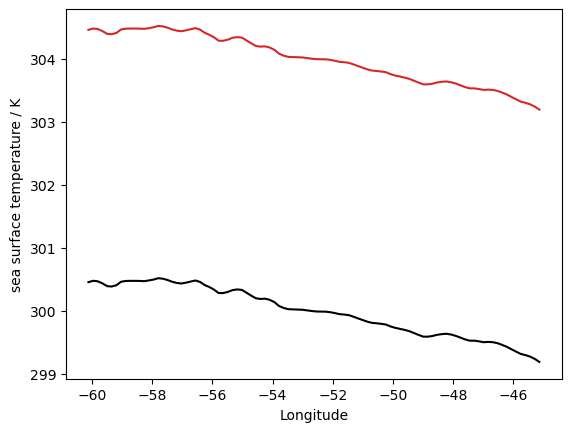

In [38]:
fig, ax = fig_compare_longitudinal_sections('t_seasfc')
fig.show()

In [15]:
data

<xarray.Dataset>
Dimensions:        (cell: 100)
Coordinates:
    lat            (cell) float64 12.23 12.24 12.24 12.24 ... 12.24 12.24 12.24
    lon            (cell) float64 -60.26 -60.11 -59.95 ... -45.29 -45.14 -44.99
  * cell           (cell) int64 10258 3147286 3144600 ... 350548 250046 2588
    time           datetime64[ns] 2020-01-09T20:00:00
Data variables: (12/15)
    u_10m          (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    v_10m          (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    rh_2m          (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    t_2m           (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    qv_2m          (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    t_seasfc       (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    ...             ...
    tqc_dia        (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    tqi_dia        (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    rain_gsp_rate  (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    tot_prec       (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    clct           (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    pres_sfc       (cell) float32 dask.array<chunksize=(100,), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

In [3]:
dir(fh)

['Audio',
 'CustomCatalog',
 'MinIntake',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'all_module_files',
 'basename',
 'beep',
 'count_elements',
 'create_directory_structure',
 'dirname',
 'disable_warnings',
 'disk_data_from_keywords',
 'eurec4a',
 'eureca_data_from_keywords',
 'extension',
 'gb',
 'get_filelist',
 'get_hash',
 'hashlib',
 'icontime2numpytime',
 'is_netcdf',
 'list_files',
 'list_slurm_jobs',
 'list_src_files',
 'load_text_files',
 'match',
 'minutes2clockstring',
 'n_elements',
 'np',
 'os',
 'pd',
 'scancel_by_name',
 'seconds2clockstring',
 'slurm_header',
 'some_module_files',
 'sublist',
 'subprocess',
 'tb',
 'warnings',
 'xr']

In [6]:
fh.disk_data_from_keywords(path, ['DOM01_3D']

['moist_adiabatic_spinup_DOM01_3D_20200109T163000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T180000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T140000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T193000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T133000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T110000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T130000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T200000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T143000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T173000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T153000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T100000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T210000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T120000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T183000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T123000Z.nc',
 'moist_adiabatic_spinup_DOM01_3D_20200109T190000Z.nc']

In [9]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import file_handling as fh
import postprocessing as pp
import matplotlib.pyplot as plt
import calculations as cc

def ax_longitudinal_section(ax, data, var, kwargs={}):
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_compare_longitudinal_sections(varname='t_2m', time_index=143):
    fig, ax = plt.subplots()
    
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup'
data = fh.disk_data_from_keywords(path, ['DOM01_3D'])
data = pp.clean_surface_data(data)
# data = data.isel(time=time_index)
data = pp.add_grid(data)

lon = cc.minmax(data.lon)[1]
lat = np.nanmean(data.lat.values) 
lon = np.linspace(*cc.minmax(data.lon), 100)[90:99]
lat = np.ones(len(lon)) * np.nanmean(data.lat.values)
data = cc.select_nearest_cells(data, lon, lat)
data

    # timestep = data.time.values
#     ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':'warming'})

#     data = fh.eureca_data_from_keywords(['surface','DOM01'])
#     data = data.sel(time=timestep)
#     data = pp.add_grid(data)
#     ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':'control'})
#     return fig, ax

# fig, ax = fig_compare_longitudinal_sections('t_2m')
# fig.show()

<xarray.Dataset>
Dimensions:      (cell: 9, time: 29, height: 68, bnds: 2, height_2: 68)
Coordinates:
    lat          (cell) float64 12.24 12.24 12.24 12.24 ... 12.24 12.24 12.24
    lon          (cell) float64 -46.37 -46.22 -46.06 ... -45.45 -45.29 -45.14
  * cell         (cell) int64 309716 311571 314038 ... 350781 350548 250046
  * time         (time) datetime64[ns] 2020-01-09T10:00:00 ... 2020-01-09T21:...
  * height       (height) float64 83.0 84.0 85.0 86.0 ... 148.0 149.0 150.0
  * height_2     (height_2) float64 83.0 84.0 85.0 86.0 ... 148.0 149.0 150.0
Dimensions without coordinates: bnds
Data variables:
    height_bnds  (time, height, bnds) float64 dask.array<chunksize=(2, 68, 2), meta=np.ndarray>
    u            (time, height, cell) float32 dask.array<chunksize=(2, 68, 9), meta=np.ndarray>
    v            (time, height, cell) float32 dask.array<chunksize=(2, 68, 9), meta=np.ndarray>
    w            (time, height_2, cell) float32 dask.array<chunksize=(2, 68, 9), meta=np.ndarray>
    temp         (time, height, cell) float32 dask.array<chunksize=(2, 68, 9), meta=np.ndarray>
    pres         (time, height, cell) float32 dask.array<chunksize=(2, 68, 9), meta=np.ndarray>
    qv           (time, height, cell) float32 dask.array<chunksize=(2, 68, 9), meta=np.ndarray>
    qc           (time, height, cell) float32 dask.array<chunksize=(2, 68, 9), meta=np.ndarray>
    qr           (time, height, cell) float32 dask.array<chunksize=(2, 68, 9), meta=np.ndarray>
    cloud_num    (time, cell) float32 dask.array<chunksize=(2, 9), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

In [4]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import file_handling as fh

fh.log_efficiency_analysis('/work/mh1126/m300872/eureca_icon/EUREC4A/run/logs/les_test-7962538.log',1)
print('\nwhy did it crash?')

walltime:       1.317 
nodes:          50.000 
simulated time: 0.665 
simulated seconds per node hour used: 36.34155597722961

why did it crash?


/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


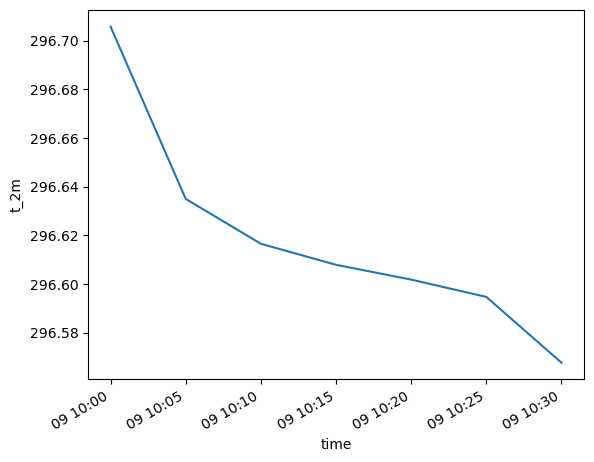

In [14]:
import postprocessing as pp

exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup_2/'
data = fh.disk_data_from_keywords(exp_dir, ['surface'])
data = pp.clean_surface_data(data)
data = data.mean(dim='cell')

data.t_2m.plot()

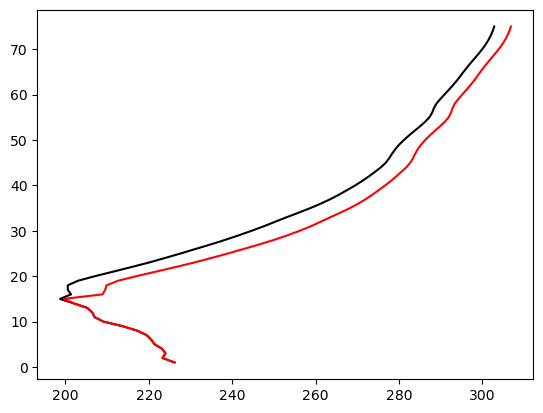

In [13]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import calculations as cc
import xarray as xr
import matplotlib.pyplot as plt

initc_path = '/work/mh1126/m300872/moist_adiabatic_rhofix/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
var = 't'
varnames = cc.add_varnames_to_default({'pressure': 'p', 'temperature': 't'})

datas = list()
data = xr.open_dataset(initc_path)
data = data[var]
data = data.mean(dim='ncells').isel(time=0)
datas.append(data)
data = xr.open_dataset(initc_path)
data = cc.apply_warming_rho_fixed(data, varnames)
data = data[var]
data = data.mean(dim='ncells').isel(time=0)
datas.append(data)
kwargs = [{'color':'black','label':'initc'}, {'color':'red','label':'initc_warmed'}]

fig, ax = plt.subplots()
for data, kwargs in zip(datas, kwargs):
    ax.plot(data, data[data.dims[0]], **kwargs)
    # ax.axvline

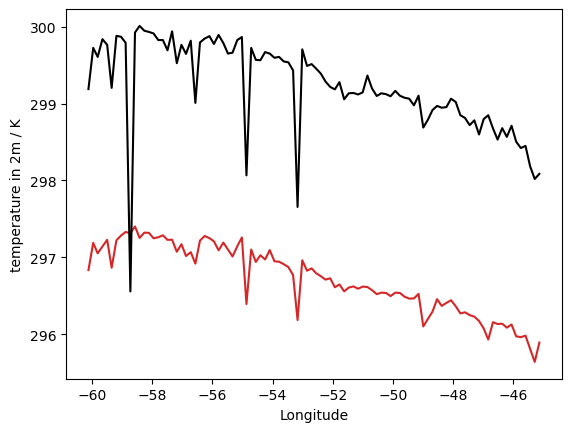

In [17]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import file_handling as fh
import postprocessing as pp
import matplotlib.pyplot as plt
import calculations as cc

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_compare_longitudinal_sections(exp_directory='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup_2',
                                      varname='t_2m', time_index=6):
    fig, ax = plt.subplots()
    data = fh.disk_data_from_keywords(exp_directory, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    data = data.isel(time=time_index)
    data = pp.add_grid(data)
    timestep = data.time.values
    ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':'warming'})

    data = fh.eureca_data_from_keywords(['surface','DOM01'])
    data = data.sel(time=timestep)
    data = pp.add_grid(data)
    ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':'control'})
    return fig, ax

fig, ax = fig_compare_longitudinal_sections('t_2m')
fig.show()

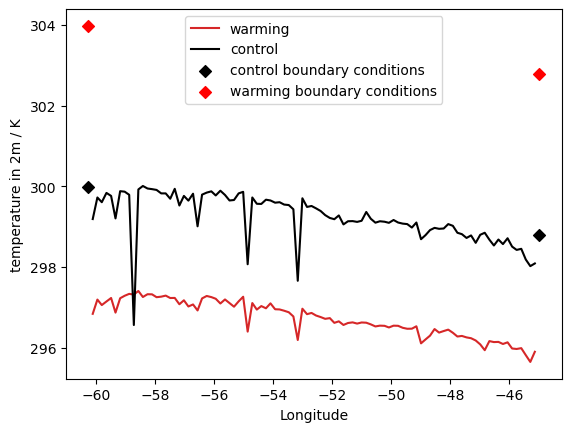

In [18]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc
import matplotlib.pyplot as plt

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    dataset = xr.open_mfdataset(files[0])
    # dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.rename({'ncells':'cell'})
    dataset = pp.add_grid(dataset, grid_path=os.path.join(path,'lateral_boundary_DOM01.grid.nc'))
    return dataset

def ax_longitudinal_section_boundaries(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

# fig, ax = plt.subplots()
fig, ax = fig_compare_longitudinal_sections('t_2m')

var = 'temp'

kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
data = open_boundary_conditions()
lon = np.asarray(cc.minmax(data.lon))
lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
data = cc.select_nearest_cells(data, lon, lat)
data = data.isel(time=0)
data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
ax.scatter(data.lon.values, data[var].values, **kwargs)

kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'D'}
data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/')
lon = np.asarray(cc.minmax(data.lon))
lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
data = cc.select_nearest_cells(data, lon, lat)
data = data.isel(time=0)
data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
ax.scatter(data.lon.values, data[var].values, **kwargs)

ax.legend()
# ax = ax_longitudinal_section_boundaries(ax, data, var, kwargs={})
fig.savefig('img/fig_lon_crosssection_boundaries.png')
fig.show()

In [ ]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc
import matplotlib.pyplot as plt

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax



def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    print(len(files), files[0])
    dataset = xr.open_dataset(files[0])
    # dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.rename({'ncells':'cell'})
    dataset = pp.add_grid(dataset, grid_path=os.path.join(path,'lateral_boundary_DOM01.grid.nc'))
    return dataset

def ax_longitudinal_section_boundaries(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_compare_longitudinal_sections(varname='t_2m', time_index=143):
    fig, ax = plt.subplots()
    
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup'
    data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    data = data.isel(time=time_index)
    data = pp.add_grid(data)
    timestep = data.time.values
    ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':'warming'})

    data = fh.eureca_data_from_keywords(['surface','DOM01'])
    data = data.sel(time=timestep)
    data = pp.add_grid(data)
    ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':'control'})
    return fig, ax

def fig_lon_crosssection_boundaries():
    fig, ax = fig_compare_longitudinal_sections('t_2m')

    var = 'temp'

    kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
    data = open_boundary_conditions()
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'D'}
    data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/')
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    ax.legend()
    return fig, ax

fig, ax = fig_lon_crosssection_boundaries()
fig.show()

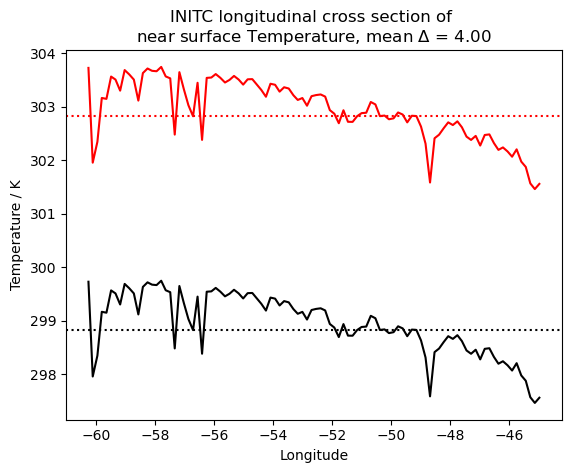

In [73]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc

import matplotlib.pyplot as plt

def open_initc_data(bc_dir, 
                    initc_rel_path='initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
                    grid_path = os.path.join(bc_ctrl, 'grids/EUREC4A_PR1250m_DOM01.nc')):
    data = xr.open_dataset(os.path.join(bc_dir, initc_rel_path))
    data = pp.clean_volume_data(data, convert_time=False)
    data = data.isel(time=0) 
    data = pp.add_grid(data, grid_path)
    data = data.isel(height=len(data.height.values)-1)
    return data

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_initc_cross_section_comparison(bc_dirs, varname):
    initc_rel_path='initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
    grid_path = os.path.join(bc_ctrl, 'grids/EUREC4A_PR1250m_DOM01.nc')

    data = [open_initc_data(dir_path) for dir_path in bc_dirs]
    kwargs = [{'color':'black', 'label':fh.basename(bc_ctrl)}, {'color':'red', 'label':fh.basename(bc_warm)}]

    fig, ax = plt.subplots()
    for d, kw in zip(data, kwargs):
        ax = ax_longitudinal_section(ax, d, varname, kw)
        ax.axhline(d[varname].mean(dim='cell'), ls=':', **kw)
    mean_diff = np.abs(data[0][varname].mean(dim="cell").values - data[1][varname].mean(dim="cell").values)
    ax.set_title(f'INITC longitudinal cross section of \nnear surface {d[varname].attrs["long_name"]}, mean $\Delta$ = {mean_diff:.2f}')
    return fig, ax

def fixed_fig_initc_cross_section_comparison():
    bc_ctrl = '/work/mh1126/m300872/unchanged/'
    bc_warm = '/work/mh1126/m300872/moist_adiabatic_rhofix/'
    return fig_initc_cross_section_comparison([bc_ctrl, bc_warm], 't')
    
fig, ax = fixed_fig_initc_cross_section_comparison()
fig.show()

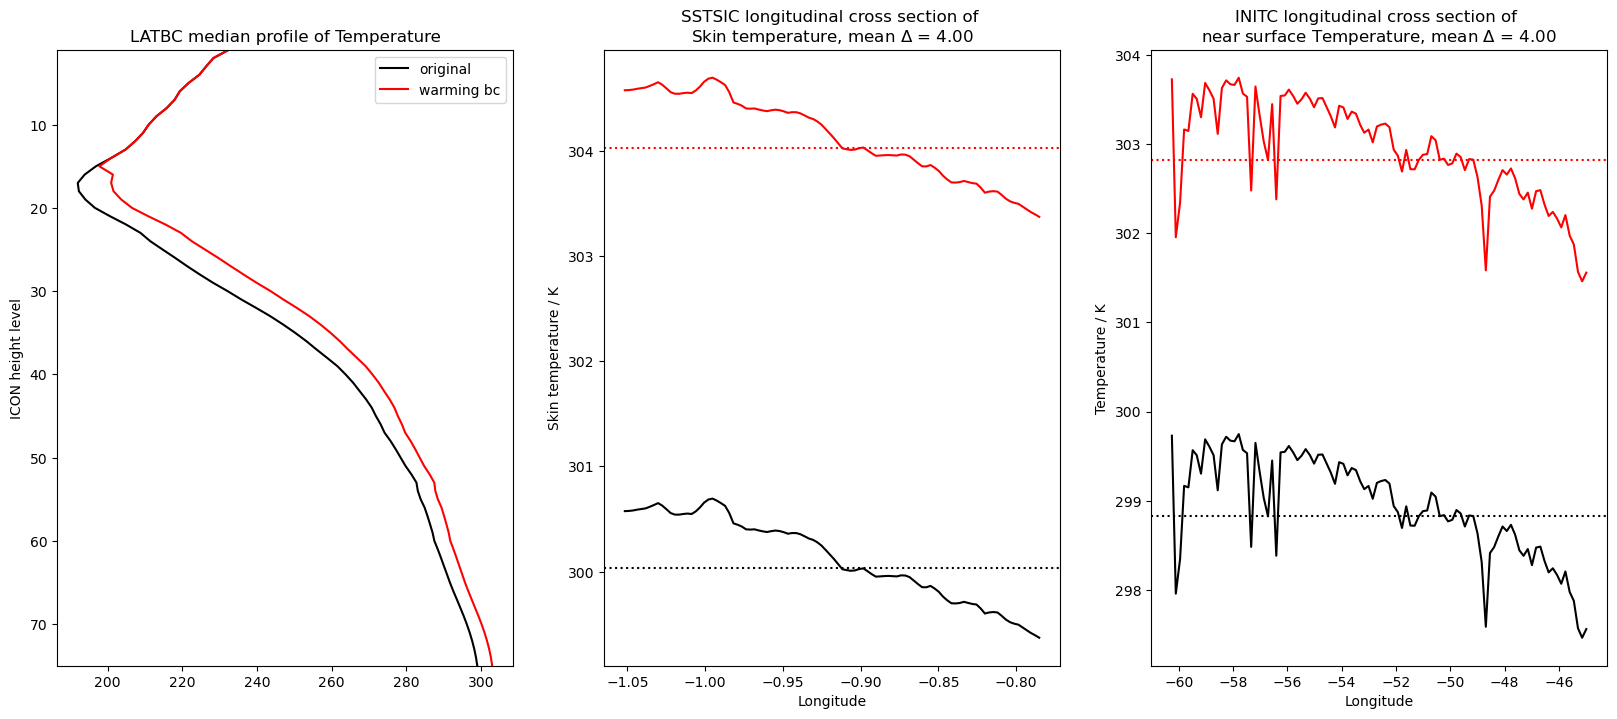

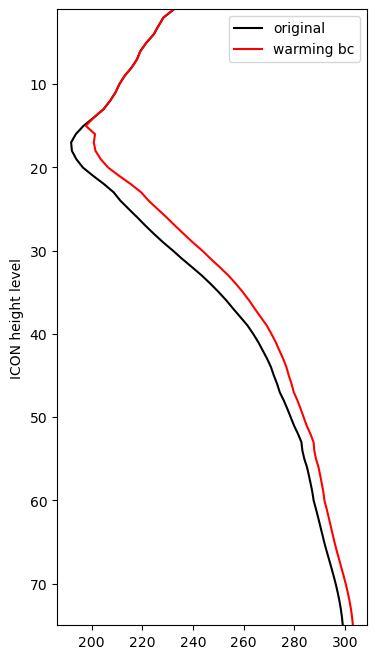

In [78]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import xarray as xr
import calculations as cc
import matplotlib.pyplot as plt
import numpy as np

import importlib
importlib.reload(cc)
fig, ax = fig_compare_boundary_condition_profiles(['/work/mh1126/m300872/unchanged/', '/work/mh1126/m300872/moist_adiabatic_rhofix/'])
# fig.savefig('img/fig_compare_boundary_condition_profiles.png')
fig.show()

/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf], dtype=float32)

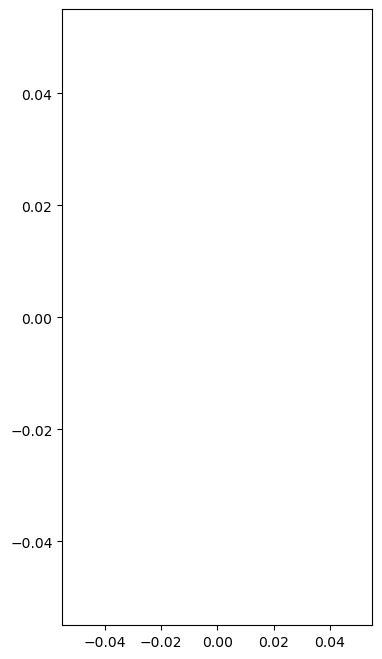

In [138]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import postprocessing as pp
import importlib; importlib.reload(pp)
import file_handling as fh

exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup_3'
data = fh.disk_data_from_keywords(exp_dir, ['spinup_3_DOM01_3D'])
data = pp.clean_volume_data(data)
data = data.isel(time=1)
data = data.mean(dim='cell', skipna=True, keep_attrs=True)
data

varname = 'temp'
fig, ax = plt.subplots(figsize=(4,8))
ax.plot(data[varname].values, data[data[varname].dims[0]].values)
# # ax.set_ylim(data[data.temp.dims[0]].values[-1], data[data.temp.dims[0]].values[0])

data[varname].values

/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


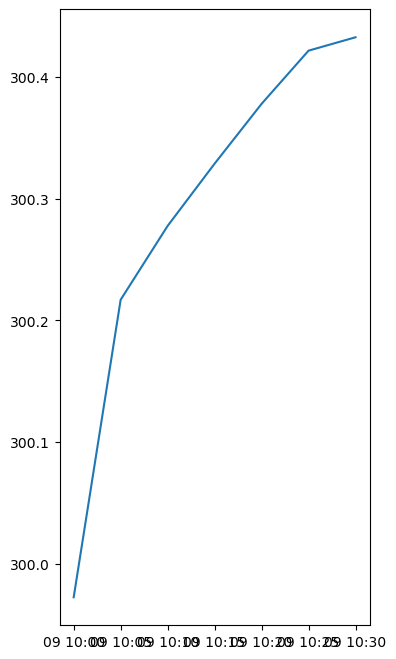

In [153]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import postprocessing as pp
import importlib; importlib.reload(pp)
import file_handling as fh

exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_spinup_3'
data = fh.disk_data_from_keywords(exp_dir, ['spinup_3_DOM01_surface'])
data = pp.clean_surface_data(data)
data = data.mean(dim='cell', skipna=True, keep_attrs=True)
data

varname = 't_2m'
fig, ax = plt.subplots(figsize=(4,8))
ax.plot(data.time.values, data[varname].values)
fig.show()


# ax.plot(data[varname].values, data[data[varname].dims[0]].values)
# # # ax.set_ylim(data[data.temp.dims[0]].values[-1], data[data.temp.dims[0]].values[0])

# data[varname].values

/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


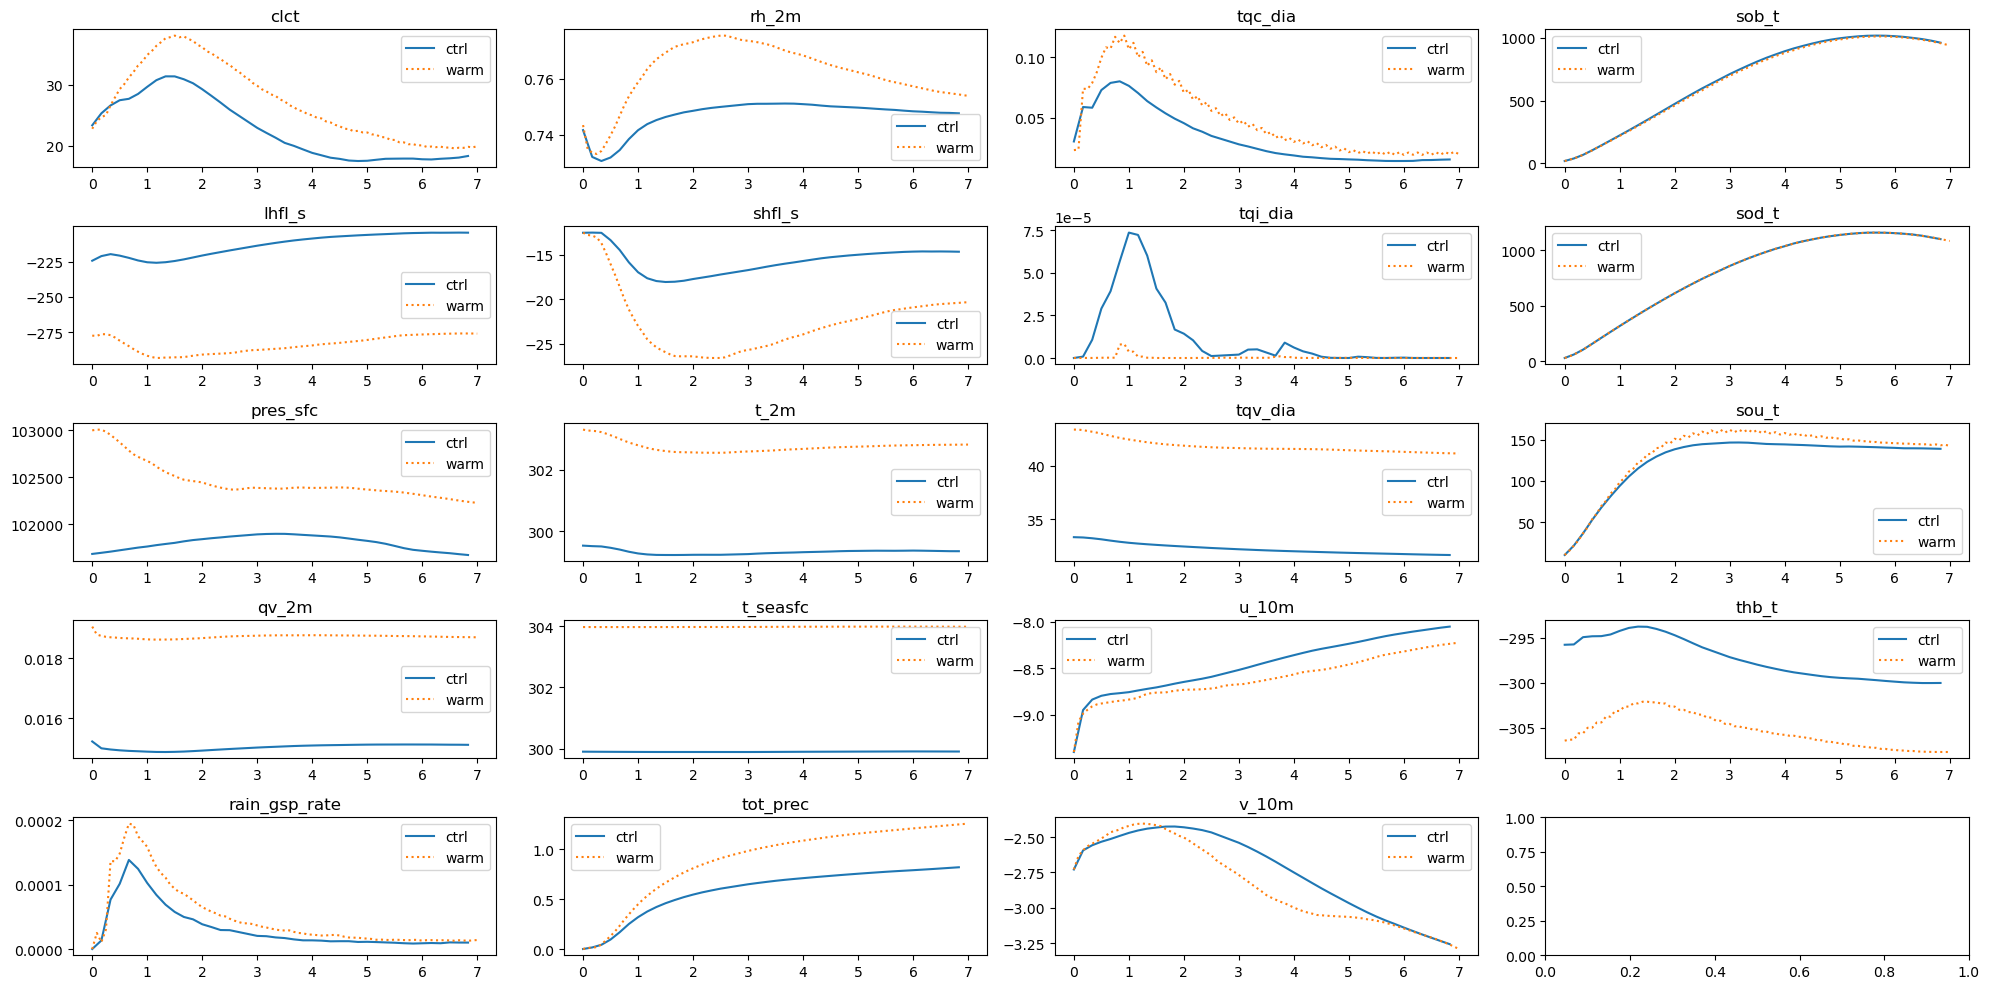

In [18]:
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import eurec4a
import xarray as xr    
import numpy as np
import pandas as pd
import calculations as cc
import postprocessing as pp
import importlib; importlib.reload(pp)
import matplotlib.pyplot as plt
import os
import file_handling as fh
from datetime import datetime

def save_composit_timeseries(path, savename, cut_borders=True):
    '''
    Loads surface and radiation data files from the given path, computes the mean for each, 
    merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - path (str): Path to the directory containing surface and radiation data files.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, drop_dims=False, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def save_matching_eurecadata(data_to_match, savename, cut_borders=True):
    '''
    Loads surface and radiation data from the EUREC4A dataset, aligns it with the given dataset, 
    computes the mean for each, merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - data_to_match (xarray.Dataset): Dataset used for aligning the EUREC4A data.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', skipna=True, keep_attrs=True)
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.radiation_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', skipna=True, keep_attrs=True).drop_vars('height_bnds').drop_dims(['height'])
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False):
    '''
    Generates a grid of plots displaying mean data from multiple sources.

    Args:
    - data (list): List of xarray Datasets.
    - labels (list): Labels for the plotted data.
    - kwargs (list, optional): Additional arguments for plotting functions. Defaults to False.
    - verbose (bool, optional): Verbosity of plot generation. Defaults to False.
    - integral (bool, optional): Whether to compute and display the mean of each dataset. Defaults to False.
    - mean (bool, optional): If True, plots a horizontal line representing the mean value. Defaults to False.

    Returns:
    - plt.Figure: The generated figure.
    - np.ndarray: Axes objects of the figure.
    '''
    if not kwargs: kwargs = [dict() for d in data]
    m,n = cc.isqrt(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k)) 

    for i,var in enumerate(list(data[0])):
        ax = axs[positions[i]]
        for j, d in enumerate(data):
            if verbose: print(f'{i*(j+1) + j} {var}', end=', ')
            if mean:
                ax.axhline(0, label=None, color='black', lw=.5)
                integral = np.mean(d[var].values[d[var].values != -np.inf])
                ax.axhline(integral, label=f'mean({labels[j]}) = {integral:2f}', ls=':')
            t = d[var].time.values
            t = pd.to_datetime(t)
            t = t - d[var].time.values[0]
            t = t.total_seconds() / (60*60)
            y = d[var].values
            ax.plot(t, y, label=labels[j], **kwargs[j])
        ax.set_title(var)
        ax.legend()
    if verbose: print('done')
    return fig, axs

def fig_all_domain_means_warmingrun(data_directory):
    '''
    Generates and displays a grid of plots showing mean data from different datasets 
    related to a warming simulation and a control dataset.

    Args:
    - data_directory (str): Path to the directory containing the data files.

    Returns:
    - plt.Figure: The generated figure.
    - np.ndarray: Axes objects of the figure.
    '''
    today = datetime.today().strftime('%Y%m%d')
    warming_timeseries = f'data/moistadabatic_{today}.nc'
    control_timeseries = f'data/{fh.basename(path)}_{today}.nc'

    if not os.path.exists(warming_timeseries): 
        save_composit_timeseries(data_directory, warming_timeseries)
    if not os.path.exists(control_timeseries):
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries)

    ctrl = xr.open_dataset(control_timeseries)
    warm = xr.open_dataset(warming_timeseries)
    data = {'ctrl':ctrl, 'warm':warm}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [dict()] * (len(data)-1) + [{'ls' : ':'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=False)
    np.ravel(axs)[0].legend()
    fig.tight_layout()
    return fig, axs

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
fig, ax = fig_all_domain_means_warmingrun(path)
fig.savefig(f'img/fig_all_domain_means_warmingrun_{fh.basename(path)}.png')
fig.show()

/home/m/m300872/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


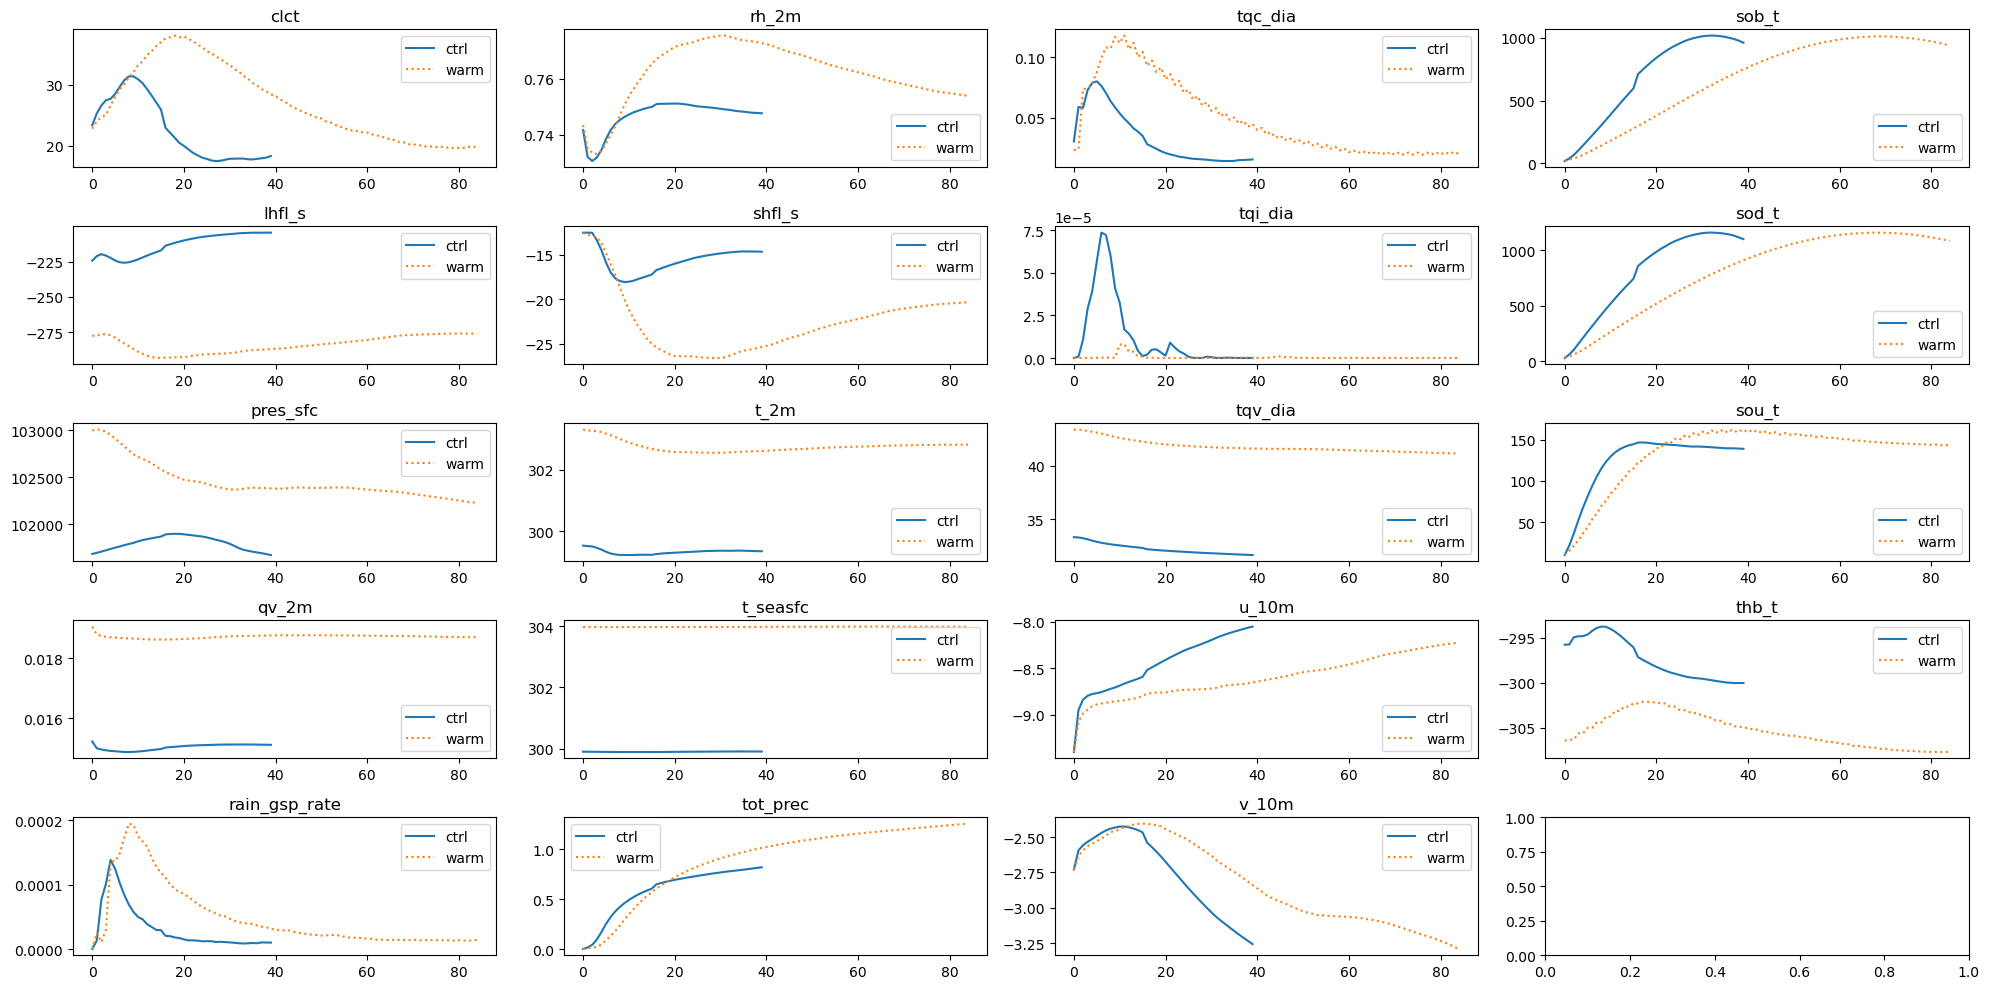

In [4]:
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
fig, ax = fig_all_domain_means_warmingrun(path)
fig.savefig(f'img/fig_all_domain_means_warmingrun_{fh.basename(path)}.png')
fig.show()

In [6]:
7 * 60 / 5

84.0

In [20]:
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04'
d = fh.disk_data_from_keywords(path, ['surface'])
d = pp.clean_surface_data(d)
d = d.mean(dim='cell')
d.lhfl_s.values

array([-266.93143, -266.6809 , -265.10788, -264.62106, -265.0255 ,
       -266.3549 , -268.10446, -269.74033, -271.24585, -272.728  ,
       -274.03162, -275.26166, -276.2818 ], dtype=float32)

In [58]:
import os
import warnings




file = '/work/mh1126/m300872/eureca_icon/EUREC4A/run/exp.moist_adiabatic.run'
len(read_file(file))
archive_file(file)

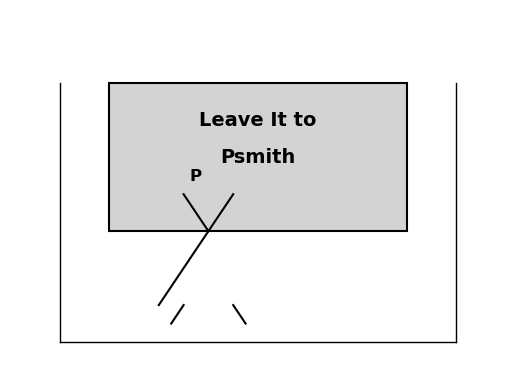

In [56]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Background color
ax.set_facecolor('#FFFFE0')

# Draw a book
book_color = '#D3D3D3'
ax.fill([0.2, 0.2, 0.8, 0.8], [0.4, 0.8, 0.8, 0.4], book_color, edgecolor='black', lw=1.5, zorder=-1)
ax.text(0.5, 0.7, "Leave It to", ha='center', va='center', fontsize=14, fontweight='bold')
ax.text(0.5, 0.6, "Psmith", ha='center', va='center', fontsize=14, fontweight='bold')

# Draw characters (basic shapes representing people)
ax.plot([0.3, 0.4], [0.2, 0.4], color='black')  # Body
ax.plot([0.4, 0.35], [0.4, 0.5], color='black')  # Arms
ax.plot([0.4, 0.45], [0.4, 0.5], color='black')  # Arms
ax.plot([0.35, 0.325], [0.2, 0.15], color='black')  # Legs
ax.plot([0.45, 0.475], [0.2, 0.15], color='black')  # Legs
ax.text(0.375, 0.55, "P", ha='center', va='center', fontsize=12, fontweight='bold')

# Additional details (like a shelf)
ax.plot([0.1, 0.9], [0.1, 0.1], color='black', lw=1)  # Shelf
ax.plot([0.1, 0.1], [0.1, 0.8], color='black', lw=1)  # Side of the shelf
ax.plot([0.9, 0.9], [0.1, 0.8], color='black', lw=1)  # Side of the shelf

# Styling
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Show the scene
plt.show()


In [48]:
def try_remove(path):
    try:os.remove(path)
    except: pass

def save_composit_timeseries(path, savename, cut_borders=True):
    '''
    Loads surface and radiation data files from the given path, computes the mean for each, 
    merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - path (str): Path to the directory containing surface and radiation data files.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    datasets = list()
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    for f in files: print(f)
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    print(data.dims)
    print(data.time.values)
    data = data.mean(dim='cell', skipna=True, keep_attrs=True)
    datasets.append(data)
    print(data.dims)
    print(data.time.values)
    
#     files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
#     for f in files: print(f)
#     data = pp.open_mfdataset_with_timedoubles(files)
#     data = pp.clean_surface_data(data, drop_dims=False, convert_time=True)
#     if cut_borders:
#         data = pp.add_grid(data)
#         data = pp.cut_borders(data)
#     print(data.dims)
#     print(data.time.values)
#     radiation = data.mean(dim='cell', skipna=True, keep_attrs=True)
    
#     data = xr.merge(pp.time_overlap([surface,radiation]))
    print(data.time.values)
    data.to_netcdf(savename)

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04'
tempfile = '/work/mh1126/m300872/temp_e916dd9499439a662f479c2dc196f05547a97916/timeseries.nc'
try_remove(tempfile)
save_composit_timeseries(path, tempfile, cut_borders=0)
d = xr.open_dataset(tempfile)
d.lhfl_s.values

/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04/moist_adiabatic_04_DOM01_surface_20200109T102000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04/moist_adiabatic_04_DOM01_surface_20200109T110000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04/moist_adiabatic_04_DOM01_surface_20200109T105500Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04/moist_adiabatic_04_DOM01_surface_20200109T104000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04/moist_adiabatic_04_DOM01_surface_20200109T104500Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04/moist_adiabatic_04_DOM01_surface_20200109T102500Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04/moist_adiabatic_04_DOM01_surface_20200109T100000Z.nc
/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04/moist_adiabatic_04_DOM01_surface_20200109T101500Z.nc


array([-266.93143, -266.6809 , -265.10788, -264.62106, -265.0255 ,
       -266.3549 , -268.10446, -269.74033, -271.24585, -272.728  ,
       -274.03162, -275.26166, -276.2818 ], dtype=float32)

In [113]:
def ax_compare_boundary_condition_profiles(ax, bc_dirs, varname='temp'):
    data = [open_latbc_data_profile(bc) for bc in bc_dirs]
    kwargs = [{'label':'original', 'color':'black'}, {'label':'warming bc', 'color':'red'}]
    
    for d, kwarg in zip(data, kwargs):
        ax.plot(d[varname].values, d[d[varname].dims[0]].values, **kwarg)
    ax.set_ylim(d[d.qv.dims[0]].values[-1], d[d.qv.dims[0]].values[0])
    ax.legend()
    try:    ax.set_xlabel(f'{warming[varname].attrs["long_name"]} / {warming[varname].attrs["units"]}')
    except: pass
    ax.set_ylabel('ICON height level')
    ax.set_title(f'LATBC median profile of {d[varname].attrs["long_name"]}')
    return ax

import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import xarray as xr
import calculations as cc
import matplotlib.pyplot as plt
import numpy as np

import importlib
importlib.reload(cc)

def fig_compare_boundary_condition_profiles():
    bc_dir  = '/work/mh1126/m300872/unchanged/'
    bc_file = 'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010812.nc'
    path = os.path.join(bc_dir, bc_file)

    profiles, kwargs = list(), list()
    profile = xr.open_dataset(os.path.join(bc_dir, bc_file))
    profile = profile.isel(time=0).median(dim='ncells', keep_attrs=True)
    profile = cc.add_relative_humidity(profile)
    profiles.append(profile)
    kwargs.append({'label':'original', 'color':'black'})

    profile = xr.open_dataset(os.path.join('/work/mh1126/m300872/moist_adiabatic_rhofix/', bc_file))
    profile = profile.isel(time=0).median(dim='ncells', keep_attrs=True)
    profile = cc.add_relative_humidity(profile)
    profiles.append(profile)
    kwargs.append({'label':'warming bc', 'color':'red'})

    profile = xr.open_dataset(path).isel(time=0).median(dim='ncells')
    varnames = cc.get_varnames()
    varnames['full_level_height'] = 'height_3'
    profile = cc.apply_warming_rho_fixed(profile, varnames)
    profile = cc.add_relative_humidity(profile)
    profiles.append(profile)
    kwargs.append({'label':'warmed control bc', 'color':'purple', 'ls':':'})

    var = 'temp'

    fig, ax = plt.subplots(figsize=(4,8))
    for profile, kwarg in zip(profiles, kwargs):
        ax.plot(profile[var].values, profile[profile[var].dims[0]].values, **kwarg)
    ax.set_ylim(profile[profile.qv.dims[0]].values[-1], profile[profile.qv.dims[0]].values[0])
    ax.legend()
    try:    ax.set_xlabel(f'{warming[var].attrs["long_name"]} / {warming[var].attrs["units"]}')
    except: pass
    return fig, ax

fig, ax = fig_compare_boundary_condition_profiles()
fig.savefig('img/fig_compare_boundary_condition_profiles.png')
fig.show()

ValueError: dimension 'time' already exists as a scalar variable

In [47]:
def clean_surface_data(dataset, 
                       rename_vars={'ncells':'cell'}, 
                       drop_dims={'height':10, 'height_2':2},
                       dim_order=['time', 'cell'],
                       convert_time=True):
    """
    Clean and manipulate a EUREC4A-LES surface data xarray dataset.

    This function performs data cleaning and manipulation operations on a surface data xarray dataset. 
    It is meant to stardardise EUREC4A-LES model output. It renames variables, drops dimensions, reorders dimensions, 
    and convert the 'time' variable to Python datetime objects if needed.

    Args:
        dataset (xarray.Dataset): An xarray dataset containing surface data.
        rename_vars (dict, optional): A dictionary for renaming variables (default is {'ncells':'cell'}).
        drop_dims (dict, optional): A dictionary specifying dimensions and their associated size values to drop (default is {'height':10, 'height_2':2}).
        dim_order (list, optional): A list specifying the desired dimension order (default is ['time', 'cell']).
        convert_time (bool, optional): Whether to convert the 'time' variable to Python datetime objects (default is True).

    Returns:
        xarray.Dataset: A cleaned and manipulated xarray dataset.

    Example:
        >>> cleaned_dataset = clean_surface_data(xarray.open_dataset("example_surface_DOM01.nc"))
    """
    if rename_vars:
        dataset = dataset.rename(rename_vars)
    if drop_dims:
        for drop in [{key: value} for key, value in drop_dims.items()]:
            try:
                dataset = dataset.sel(drop).drop_vars(list(drop))
            except:
                pass
    if dim_order:
        dataset = dataset[dim_order + list(dataset)]
    if convert_time:
        dataset = dataset.assign_coords(time=icon2datetime(dataset.time.values))
    return dataset

def save_composit_timeseries(path, savename, cut_borders=True):
    '''
    Loads surface and radiation data files from the given path, computes the mean for each, 
    merges them based on time overlap, and saves the resulting dataset as a netCDF file.

    Args:
    - path (str): Path to the directory containing surface and radiation data files.
    - savename (str): Name for the output netCDF file.
    - cut_borders (bool, optional): Whether to cut the border regions. Defaults to True.
    '''
    datasets = list()
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    for f in files: print(f)
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data, convert_time=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    print(data.dims)
    print(data.time.values)
    data = data.mean(dim='cell', skipna=True, keep_attrs=True)
    datasets.append(data)
    print(data.dims)
    print(data.time.values)
    
    
path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04'
# tempfile = '/work/mh1126/m300872/temp_e916dd9499439a662f479c2dc196f05547a97916/timeseries.nc'
# try_remove(tempfile)
# save_composit_timeseries(path, tempfile, cut_borders=0)
# d = xr.open_dataset(tempfile)
# d.lhfl_s.values

cut_borders = 1

files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
# for f in files: print(f)
data = pp.open_mfdataset_with_timedoubles(files)
print(data.lhfl_s.values)
data = pp.clean_surface_data(data, convert_time=True)
print(data.lhfl_s.values)
print('before cut borders', data.dims)

data = pp.add_grid(data)
data.lon.values
dataset = data
borders = pp.default_cutout_rectangle('DOM02')
dataset = pp.cut_rectangle(dataset, borders)
data = dataset
print('after add grid', data.dims)
# data = pp.cut_borders(data)
# print('after cut borders', data.dims)
# print(data.time.values)
# print(data.lhfl_s.values)
# data = data.mean(dim='cell', skipna=True, keep_attrs=True)
# print(data.lhfl_s.values)
data

[[       nan        nan        nan ... -185.34685 -184.42032 -165.13158]
 [       nan        nan        nan ... -181.18982 -169.32698 -166.10146]
 [       nan        nan        nan ... -166.25806 -141.4444  -169.52948]
 ...
 [       nan        nan        nan ... -193.04726 -163.99197 -213.7777 ]
 [       nan        nan        nan ... -196.37297 -163.65607 -214.4969 ]
 [       nan        nan        nan ... -194.96783 -162.62915 -220.00249]]
[[       nan        nan        nan ... -185.34685 -184.42032 -165.13158]
 [       nan        nan        nan ... -181.18982 -169.32698 -166.10146]
 [       nan        nan        nan ... -166.25806 -141.4444  -169.52948]
 ...
 [       nan        nan        nan ... -193.04726 -163.99197 -213.7777 ]
 [       nan        nan        nan ... -196.37297 -163.65607 -214.4969 ]
 [       nan        nan        nan ... -194.96783 -162.62915 -220.00249]]
before cut borders Frozen({'time': 13, 'cell': 4528560})
after add grid Frozen({'cell': 0, 'time': 13})


<xarray.Dataset>
Dimensions:        (cell: 0, time: 13)
Coordinates:
    lat            (cell) float64 
    lon            (cell) float64 
  * cell           (cell) int64 
  * time           (time) datetime64[ns] 2020-01-09T10:00:00 ... 2020-01-09T1...
Data variables: (12/15)
    u_10m          (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    v_10m          (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    rh_2m          (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    t_2m           (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    qv_2m          (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    t_seasfc       (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    ...             ...
    tqc_dia        (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    tqi_dia        (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    rain_gsp_rate  (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    tot_prec       (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    clct           (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
    pres_sfc       (time, cell) float32 dask.array<chunksize=(1, 0), meta=np.ndarray>
Attributes: (12/18)
    ICON_grid_file_uri:   
    centre:               78
    crs_id:               urn:ogc:def:cs:EPSG:6.0:6422
    crs_name:             Spherical 2D Coordinate System
    ellipsoid_name:       Sphere
    global_grid:          0
    ...                   ...
    semi_major_axis:      6371229.0
    source:               svn://xceh.dwd.de/for0adm/SVN_icontools/tags/iconto...
    subcentre:            255
    title:                ICON grid description
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215

In [44]:
data.mean(dim='cell').t_2m.values

array([303.1559 , 303.11176, 303.08896, 303.07413, 303.04968, 303.0114 ,
       302.9665 , 302.9187 , 302.86774, 302.81503, 302.76263, 302.71512,
       302.6715 ], dtype=float32)

1023 /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc
1023 /work/mh1126/m300872/moist_adiabatic_rhofix/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc


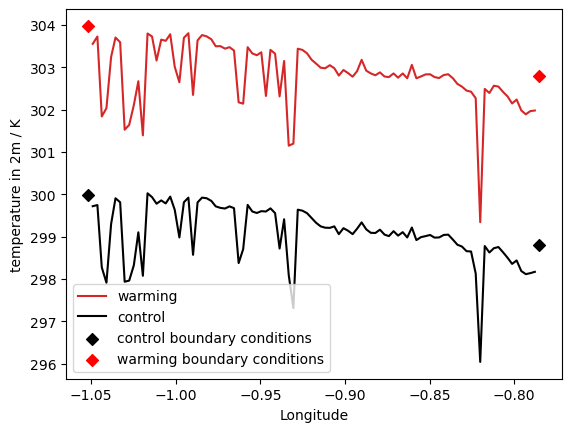

In [2]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import os
import file_handling as fh

import numpy as np
import xarray as xr
import postprocessing as pp
import calculations as cc
import matplotlib.pyplot as plt

def ax_longitudinal_section(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_compare_longitudinal_sections(varname='t_2m', time_index=12):
    fig, ax = plt.subplots()
    
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_04'
    data = fh.disk_data_from_keywords(path, ['surface','DOM01'])
    data = pp.clean_surface_data(data)
    data = data.isel(time=time_index)
    data = pp.add_grid(data)
    timestep = data.time.values
    ax = ax_longitudinal_section(ax, data, varname, {'color':'tab:red', 'label':'warming'})

    data = fh.eureca_data_from_keywords(['surface','DOM01'])
    data = data.sel(time=timestep)
    data = pp.add_grid(data)
    ax = ax_longitudinal_section(ax, data, varname, {'color':'black', 'label':'control'})
    return fig, ax

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    # print(len(files), files[0])
    dataset = xr.open_dataset(files[0])
    # dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.rename({'ncells':'cell'})
    dataset = pp.add_grid(dataset, grid_path=os.path.join(path,'lateral_boundary_DOM01.grid.nc'))
    return dataset

def ax_longitudinal_section_boundaries(ax, data, var, kwargs={}):
    lon = np.linspace(*cc.minmax(data.lon), 100)
    lat = np.ones(100) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    ax.plot(data[var].lon.values, data[var].values, **kwargs)
    ax.set_xlabel('Longitude')
    ax.set_ylabel(f'{data[var].attrs["long_name"]} / {data[var].attrs["units"]}')
    return ax

def fig_fig_lon_crosssection_boundaries():
    fig, ax = fig_compare_longitudinal_sections('t_2m')

    var = 'temp'

    kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
    data = open_boundary_conditions()
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'D'}
    data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/')
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    ax.legend()
    return fig, ax

fig, ax = fig_fig_lon_crosssection_boundaries()
# fig.savefig('img/fig_lon_crosssection_boundaries_.png')
fig.show()

1023 /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc
1023 /work/mh1126/m300872/moist_adiabatic_rhofix/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc


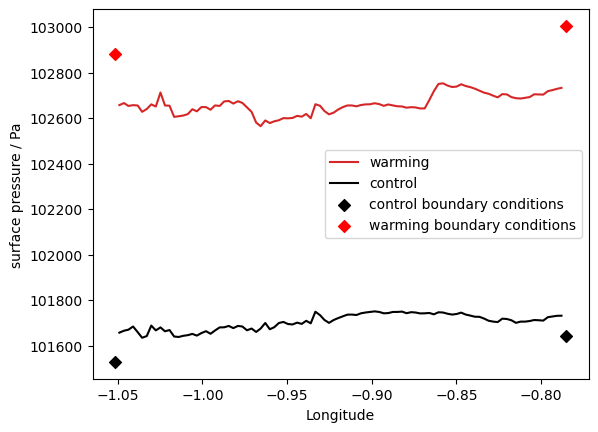

In [5]:
def fig_fig_lon_crosssection_boundaries():
    fig, ax = fig_compare_longitudinal_sections('pres_sfc')

    var = 'pres'

    kwargs = {'label':'control boundary conditions', 'color':'black', 'marker':'D'}
    data = open_boundary_conditions()
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    kwargs = {'label':'warming boundary conditions', 'color':'red', 'marker':'D'}
    data = open_boundary_conditions('/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/')
    lon = np.asarray(cc.minmax(data.lon))
    lat = np.ones(len(lon)) * np.nanmean(data.lat.values) 
    data = cc.select_nearest_cells(data, lon, lat)
    data = data.isel(time=0)
    data = data.isel({ data[var].dims[0] : len(data[data[var].dims[0]])-1 })
    ax.scatter(data.lon.values, data[var].values, **kwargs)

    ax.legend()
    return fig, ax

fig, ax = fig_fig_lon_crosssection_boundaries()
# fig.savefig('img/fig_lon_crosssection_boundaries_.png')
fig.show()

In [10]:
path = '/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/'
path = '/work/mh1126/m300872/unchanged/latbc/'
dataset = open_boundary_conditions(path)
dataset = dataset.mean(dim=['cell'], keep_attrs=True)
dataset = dataset.isel(time=0)
dataset

1023 /work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc


<xarray.Dataset>
Dimensions:        (vertices: 3, height: 76, bnds: 2, height_2: 76, height_3: 75)
Coordinates:
    time           datetime64[ns] 2020-01-08T01:00:00
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 73.0 74.0 75.0 76.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 73.0 74.0 75.0 76.0
  * height_3       (height_3) float64 1.0 2.0 3.0 4.0 ... 72.0 73.0 74.0 75.0
Dimensions without coordinates: vertices, bnds
Data variables: (12/15)
    clon_bnds      (vertices) float64 -0.92 -0.92 -0.92
    clat_bnds      (vertices) float64 0.2141 0.2141 0.2141
    height_bnds    (height, bnds) float64 1.0 0.0 2.0 0.0 ... 75.0 0.0 76.0 0.0
    height_3_bnds  (height_3, bnds) float64 1.0 2.0 2.0 3.0 ... 75.0 75.0 76.0
    z_ifc          (height) float32 3.5e+04 3.283e+04 3.128e+04 ... 22.67 2.675
    w              (height_2) float32 0.0 -0.004472 ... 1.545e-05 6.512e-05
    ...             ...
    qr             (height_3) float32 0.0 0.0 0.0 ... 6.674e-07 6.6e-07 6.57e-07
    qs             (height_3) float32 0.0 0.0 0.0 ... 9.7e-27 1.158e-28
    u              (height_3) float32 -15.26 -20.15 -21.66 ... -8.212 -7.428
    v              (height_3) float32 2.527 1.998 0.6742 ... -3.945 -3.561
    temp           (height_3) float32 235.2 230.2 225.3 ... 298.4 298.8 299.1
    pres           (height_3) float32 623.4 818.7 ... 1.012e+05 1.016e+05
Attributes:
    Creator:              ICONSUB - ICOsahedral Nonhydrostatic model SUBgrid ...
    grid_level:           12
    grid_root:            2
    source:               git@git.mpimet.mpg.de:dwd_icon_tools.git, branch ma...
    number_of_grid_used:  0
    uuidOfHGrid:          f70a2faa-0fa0-b934-f7fc-f3b9e8c72f20
    max_refin_c_ctrl:     14
    uuidOfOriginalHGrid:  00000000-0000-0000-0000-000000000000

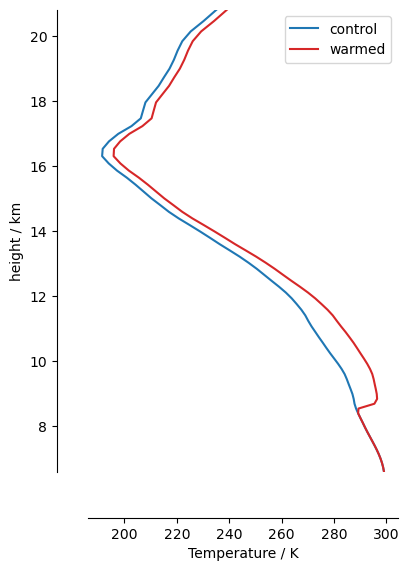

In [12]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import numpy as np
import xarray as xr
import file_handling as fh
import metpy.calc
import metpy.units
import postprocessing as pp
# import eurec4a
import calculations as cc

import matplotlib.pyplot as plt
import plot_utils as pu

def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    dataset = xr.open_mfdataset(files[0])
    dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    return dataset

def ax_vertical_profile(ax, dataset, var, kwargs={}):
    ax.plot(dataset[var], dataset[dataset[var].dims[0]].values / 1000, **kwargs)
    ax.set_ylim(dataset[dataset[var].dims[0]].values[-1] / 1000, dataset[dataset[var].dims[0]].values[0] / 1000)
    ax.set_ylabel('height / km')
    try: ax.set_xlabel(dataset[var].attrs['long_name'] + ' / ' + dataset[var].attrs['units'] )
    except: pass
    # https://matplotlib.org/2.0.2/examples/pylab_examples/spine_placement_demo.html
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('axes', -.1)) #
    ax.spines['left'  ].set_position(('axes', -.1)) # 
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    return ax

def fig_boundarycon():
    var = 'temp'
    dataset = open_boundary_conditions().isel(time=0)

    fig, ax = plt.subplots(figsize=(4,6))
    dataset = cc.add_relative_humidity(dataset)
    dataset = cc.replace_level_with_height(dataset, dataset[var].dims[0])
    ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:blue', 'label':'control'})
    dataset = cc.apply_warming_rho_fixed(dataset)
    dataset = cc.add_relative_humidity(dataset)
    ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:red', 'label':'warmed'})
    ax.legend()
    return fig, ax

fig, ax = fig_boundarycon()
fig.show()

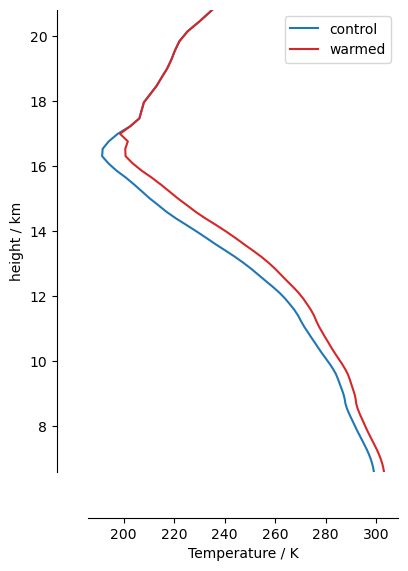

In [26]:
def open_boundary_conditions(path='/work/mh1126/m300872/unchanged/latbc/'):
    files = fh.list_files(path, ['PR1250m'], full_path=True)
    dataset = xr.open_mfdataset(files[0])
    dataset = dataset.mean(dim=['ncells'], keep_attrs=True)
    dataset = dataset.isel(time=0)
    dataset = cc.add_relative_humidity(dataset)
    dataset = cc.add_prognostic_variables(dataset)
    dataset = cc.replace_level_with_height(dataset, 'height_3')
    return dataset

def fig_boundarycon_comparison(var='temp'):
    fig, ax = plt.subplots(figsize=(4,6))
    path = '/work/mh1126/m300872/unchanged/latbc/'
    dataset = open_boundary_conditions(path)
    ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:blue', 'label':'control'})
    path = '/work/mh1126/m300872/moist_adiabatic_rhofix/latbc/'
    dataset = open_boundary_conditions(path)
    ax = ax_vertical_profile(ax, dataset, var, {'color':'tab:red', 'label':'warmed'})
    ax.legend()
    return fig, ax

fig, ax = fig_boundarycon_comparison()
fig.show()

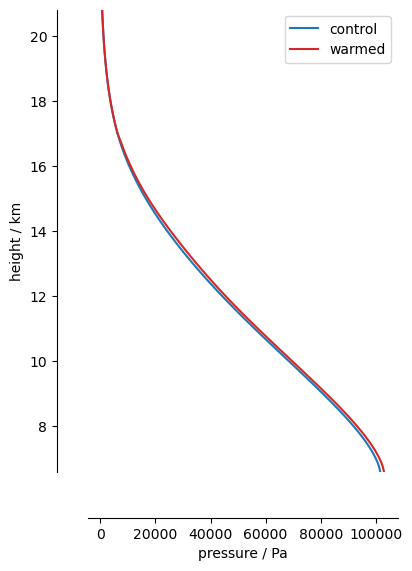

In [27]:
fig, ax = fig_boundarycon_comparison('pres')
fig.show()

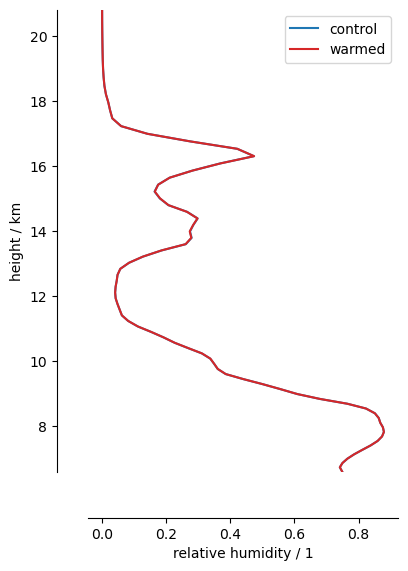

In [28]:
fig, ax = fig_boundarycon_comparison('RH')
fig.show()

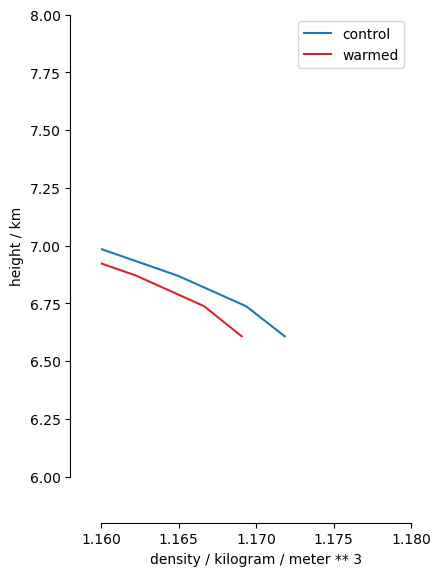

In [39]:
fig, ax = fig_boundarycon_comparison('rho')
ax.set_xlim(1.16, 1.18)
ax.set_ylim(6, 8)
fig.show()

In [ ]:
import imageio
import glob

def video_from_snapshots(files, save_path, fps=12, verbose=True):
    '''Concats frames from images in a file list and save video to path.'''
    writer = imageio.get_writer(save_path, fps=fps)
    for im in files: writer.append_data(imageio.imread(im))
    writer.close()
    if verbose: print(f'{save_path} DONE')

def make_video(prefix='ctrl', fps=6):
    # use 12 for longer videos
    folder = '/scratch/m/m300872/quiver/'
    files = sorted(glob.glob(folder+prefix+'*'))
    if len(files)>1000: files = files[0:1000]
    video_filename = f'/home/m/m300872/warm_eurec4a/03_adiabatic_warming/{prefix}_quiver.mp4'
    video_from_snapshots(files, video_filename, fps=6)
    return video_filename

prefixes = ['ctrl', 'presfix', 'rhofix']
make_video('presfix')